# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Index No: 200285E
## Name : N.V.Kannangara

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [4]:
#Function to load and process words from a file
def load_and_process_words(filepath, word_size):
    
    with open(filepath, 'r') as f:
        words = f.read().splitlines()

    words = [word.lower() for word in words] #lowercase all words
    
    words = [word for word in words if 3 < len(word) <= word_size] #filter out words that are too short or too long
    
    vocab = [word.ljust(word_size, '_') for word in words] #pad words with underscores to make them all the same length
    
    return vocab


In [8]:
#Load and process words from file
vocab = load_and_process_words('wordlist.txt', WORD_SIZE)
print(vocab[:10]) #print first 10 words 
print("Number of words in vocab: ", len(vocab)) #print number of words in vocab

['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______', 'able_________', 'aboriginal___', 'abortion_____', 'about________', 'above________']
Number of words in vocab:  8847


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** (to write answers edit this cell)

- Filtering out words with fewer than 3 letters helps avoid **overfitting**. Short words like "a", "an", and "to" are too common and don't provide much variety. The model might memorize simple patterns from these words, reducing its ability to generalize.
  
- **Longer words** provide richer context, allowing the RNN to learn more complex character-level relationships. Short words don't have enough data for the model to capture meaningful patterns, so removing them improves training quality.
  
- Ensuring words have the same length (by padding with underscores to a fixed length, like `WORD_SIZE = 13`) creates a **uniform input size**, which simplifies the RNN's processing. Neural networks expect uniform input sizes for efficient matrix operations.

- Filtering out short words improves the **efficient use of computational resources**. By eliminating unnecessary noise (short, uninformative words), the model can focus on learning from more valuable data, speeding up training and improving accuracy.

- Restricting word length helps in **balancing vocabulary size**. If too many words with varying lengths are included, it increases the model's complexity. Limiting word length helps avoid unnecessary model complexity, especially in smaller datasets or limited hardware environments.

- Overall, filtering words based on length and padding shorter words helps build a **better model** by eliminating noise, focusing on informative patterns, improving generalization, and making the model more efficient to train.


**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [28]:
def char_to_num(char):
    
    if char == '_':
        num = 0
    else:
        num = ord(char) - ord('a') + 1

    return num

def num_to_char(num):

    if num == 0:
        char = '_'
    else:
        char = chr(num + ord('a') - 1)
    
    return(char)

def word_to_numlist(word):

    numlist = torch.tensor([char_to_num(char) for char in word], dtype=torch.long)

    return(numlist)

def numlist_to_word(numlist):

    word = ''.join([num_to_char(num) for num in numlist])
    
    return(word)

In [70]:
#Example of converting a word to a list of numbers

word = vocab[88]
numlist = word_to_numlist(word)
print(word)
print("Number List: ",numlist)
print("Reconstructed word: ",numlist_to_word(numlist))


auburn_______
Number List:  tensor([ 1, 21,  2, 21, 18, 14,  0,  0,  0,  0,  0,  0,  0])
Reconstructed word:  auburn_______


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** (to write answers edit this cell)

Your claim that encoding letters as numbers based solely on their alphabetical order is a **bad approach** has valid reasoning. Here's why:

- **Loss of Meaning**: When we assign numbers based on alphabetical order, such as 'a' -> 1, 'b' -> 2, ..., 'z' -> 26, the model might infer relationships between characters that don't actually exist. For example, it may think that 'b' is closer to 'a' than 'z' because 2 is closer to 1 than to 26. However, letters don't have any intrinsic order or distance between them like numbers do, so this numeric relationship is meaningless.

- **Ordinal Encoding Pitfalls**: This approach is akin to treating letters as **ordinal data**, which implies a ranked relationship between categories. However, there is no meaningful ordinal relationship between letters in the alphabet, and treating them as such can lead the model to make incorrect assumptions about their relationships.

- **Problem of High Dimensionality**: Letters are **categorical data** in nature, meaning that each letter represents a distinct and unrelated category. When you assign numeric values to these categories, the model may falsely interpret numerical proximity as semantic similarity, leading to poor predictions and inefficiencies during training.



#### What is an Embedding Layer?

An **embedding layer** is a trainable layer in neural networks, particularly useful in handling high-dimensional categorical data like words, characters, or other types of symbolic data. Instead of representing each letter or word as a simple number, an embedding layer maps each character (or word) to a **dense vector** in a continuous vector space.

For example, rather than encoding 'a' as 1, 'b' as 2, etc., an embedding layer will assign each character a vector of floating-point numbers. These vectors are learned during the training process, and the model discovers meaningful patterns and relationships between the letters.

#### Purpose of Embedding Layers:
1. **Learn Meaningful Representations**: Instead of treating letters as isolated entities, embedding layers learn to group together letters that are used in similar contexts. This allows the model to capture **semantic meaning** or patterns, improving generalization.
  
2. **Handle Categorical Data**: Embedding layers convert categorical data (such as characters or words) into dense vectors, allowing the model to process them effectively. They help avoid the limitations of naive one-hot or ordinal encodings, where numeric distances between categories can be misleading.

3. **Dimensionality Reduction**: Instead of having high-dimensional one-hot encodings (e.g., 27 dimensions for 26 letters and an underscore), embeddings reduce the representation of each character to a **lower-dimensional space** (e.g., vectors of 5 or 10 dimensions), making training more efficient.

4. **Learn Relationships**: Embedding layers can encode relationships between characters or words that aren't obvious from simple numeric representations. For example, characters that frequently occur together or have similar usage patterns in words might be placed closer to each other in the vector space.

## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [308]:
LEARNING_RATE = 0.003

In [310]:

class autocompleteModel(nn.Module):
    # Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()
        
        # Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize the layers: embedding, LSTM, and fully connected layer
        self.embedding = nn.Embedding(alphabet_size, embed_dim)  # Embedding layer
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_size, alphabet_size)  # Fully connected layer

    # Feedforward
    def forward(self, character, hidden_state, cell_state):
        # Embed the input character
        embedded = self.embedding(character.unsqueeze(0))  # Add batch dimension
        # Feed embedded character to LSTM
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state))
        # Feed LSTM output to fully connected layer
        output = self.fc(lstm_out.squeeze(0))
        return output, hidden_state, cell_state

    # Initialize the hidden and cell states as zero tensors
    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)

    # Train the model in epochs with given vocabulary
    def trainModel(self, vocab, epochs=5, batch_size=100):
        self.train()  # Set model to training mode
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.CrossEntropyLoss()  # Use cross-entropy loss

        loss_log = []  # Store loss values

        for e in range(epochs):
            # Shuffle the vocab list at the start of each epoch
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size

            for i in range(num_iter):
                # Zero the gradients
                optimizer.zero_grad()
                total_loss = 0

                # Process batch
                vocab_batch = vocab[i*batch_size:(i+1)*batch_size]
                for word in vocab_batch:
                    # Initialize hidden and cell state for each word
                    hidden_state, cell_state = self.initial_state()
                    
                    # Convert the word into a tensor of numbers
                    word_tensor = word_to_numlist(word)
                    inputs = word_tensor[:-1]  # Input is first WORD_SIZE - 1 characters
                    targets = word_tensor[1:]  # Target is last WORD_SIZE - 1 characters

                    for c in range(WORD_SIZE - 1):
                        # Feed each character to the model
                        output, hidden_state, cell_state = self.forward(inputs[c].unsqueeze(0), hidden_state, cell_state)
                        # Compute the loss
                        loss = loss_fn(output, targets[c].unsqueeze(0))
                        total_loss += loss

                # Compute average loss, backpropagate and update the model
                total_loss /= batch_size
                total_loss.backward()
                optimizer.step()

                # Log the loss
                loss_log.append(total_loss.item())

            print(f"Epoch: {e+1}/{epochs}, Loss: {total_loss.item()}")

        # Plot the loss variation over time
        plt.plot(loss_log)
        plt.title('Training Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

    # Autocomplete function
    def autocomplete(self, sample):
        self.eval()  # Set model to evaluation mode
        completed_list = []

        for literal in sample:
            hidden_state, cell_state = self.initial_state()
            word = literal
            word_tensor = word_to_numlist(literal)
            
            for i in range(len(literal), WORD_SIZE):
                # Get the output for the next character
                output, hidden_state, cell_state = self.forward(word_tensor[-1].unsqueeze(0), hidden_state, cell_state)
                # Apply softmax to output to get probabilities
                softmax_output = torch.softmax(output, dim=1)
                # Sample from the distribution to get the next character
                next_char_idx = torch.multinomial(softmax_output, 1).item()
                next_char = num_to_char(next_char_idx)
                word += next_char
                word_tensor = torch.cat([word_tensor, torch.tensor([next_char_idx])])

            completed_list.append(word)

        return completed_list


## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

Epoch: 1/10, Loss: 18.568744659423828
Epoch: 2/10, Loss: 15.94477653503418
Epoch: 3/10, Loss: 16.38720703125
Epoch: 4/10, Loss: 15.121639251708984
Epoch: 5/10, Loss: 14.897602081298828
Epoch: 6/10, Loss: 14.390949249267578
Epoch: 7/10, Loss: 14.388601303100586
Epoch: 8/10, Loss: 14.4915132522583
Epoch: 9/10, Loss: 14.292725563049316
Epoch: 10/10, Loss: 13.797868728637695


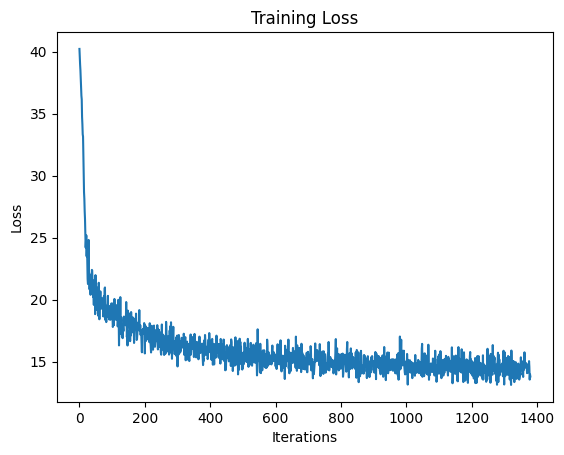

In [74]:
# Hyperparameters
embed_dim = 10
hidden_size = 20
num_layers = 1
batch_size = 64
epochs = 10

# Initialize the model
model1 = autocompleteModel(alphabet_size=27, embed_dim=embed_dim, hidden_size=hidden_size, num_layers=num_layers)

# Train the model
model1.trainModel(vocab=vocab, epochs=epochs, batch_size=batch_size)


**Answer** (to write answers edit this cell)

Epoch: 1/10, Loss: 18.28510284423828
Epoch: 2/10, Loss: 15.981904983520508
Epoch: 3/10, Loss: 15.269505500793457
Epoch: 4/10, Loss: 16.92219352722168
Epoch: 5/10, Loss: 14.578878402709961
Epoch: 6/10, Loss: 14.098430633544922
Epoch: 7/10, Loss: 13.91549301147461
Epoch: 8/10, Loss: 13.778350830078125
Epoch: 9/10, Loss: 13.464396476745605
Epoch: 10/10, Loss: 13.314997673034668


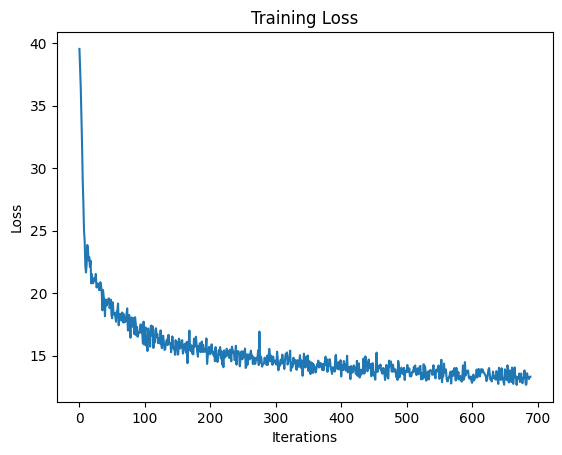

In [116]:
# Hyperparameters
embed_dim = 20
hidden_size = 50
num_layers = 1
batch_size = 128
epochs = 10

# Initialize the model
model2 = autocompleteModel(alphabet_size=27, embed_dim=embed_dim, hidden_size=hidden_size, num_layers=num_layers)

# Train the model
model2.trainModel(vocab=vocab, epochs=epochs, batch_size=batch_size)


Epoch: 1/10, Loss: 16.925262451171875
Epoch: 2/10, Loss: 16.1972599029541
Epoch: 3/10, Loss: 14.945491790771484
Epoch: 4/10, Loss: 15.488862991333008
Epoch: 5/10, Loss: 13.970194816589355
Epoch: 6/10, Loss: 12.225951194763184
Epoch: 7/10, Loss: 12.455947875976562
Epoch: 8/10, Loss: 13.504630088806152
Epoch: 9/10, Loss: 12.66465950012207
Epoch: 10/10, Loss: 12.838129997253418


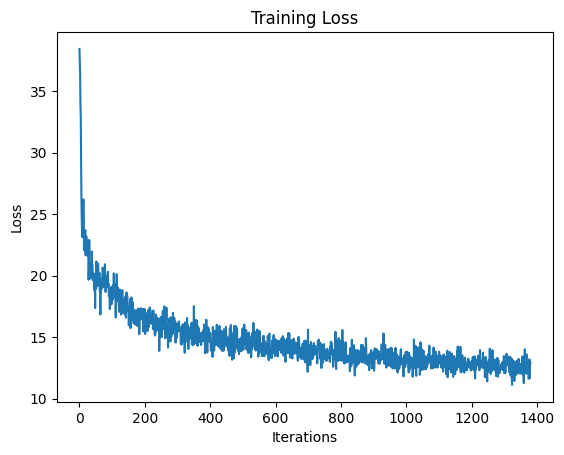

In [151]:
# Hyperparameters
embed_dim = 15
hidden_size = 40
num_layers = 2  # Increase the number of LSTM layers
batch_size = 64
epochs = 10

# Initialize the model
model3 = autocompleteModel(alphabet_size=27, embed_dim=embed_dim, hidden_size=hidden_size, num_layers=num_layers)

# Train the model
model3.trainModel(vocab=vocab, epochs=epochs, batch_size=batch_size)


Epoch: 1/50, Loss: 18.47763442993164
Epoch: 2/50, Loss: 18.451860427856445
Epoch: 3/50, Loss: 17.932729721069336
Epoch: 4/50, Loss: 16.196577072143555
Epoch: 5/50, Loss: 15.327152252197266
Epoch: 6/50, Loss: 15.321523666381836
Epoch: 7/50, Loss: 14.595664024353027
Epoch: 8/50, Loss: 13.792743682861328
Epoch: 9/50, Loss: 13.63455581665039
Epoch: 10/50, Loss: 12.99760913848877
Epoch: 11/50, Loss: 12.710309982299805
Epoch: 12/50, Loss: 12.630756378173828
Epoch: 13/50, Loss: 12.535882949829102
Epoch: 14/50, Loss: 12.782585144042969
Epoch: 15/50, Loss: 12.150469779968262
Epoch: 16/50, Loss: 11.347535133361816
Epoch: 17/50, Loss: 10.877652168273926
Epoch: 18/50, Loss: 11.15307331085205
Epoch: 19/50, Loss: 11.106191635131836
Epoch: 20/50, Loss: 10.969688415527344
Epoch: 21/50, Loss: 11.19965648651123
Epoch: 22/50, Loss: 10.557454109191895
Epoch: 23/50, Loss: 9.964256286621094
Epoch: 24/50, Loss: 10.264413833618164
Epoch: 25/50, Loss: 9.59762191772461
Epoch: 26/50, Loss: 9.9872407913208
Epoch:

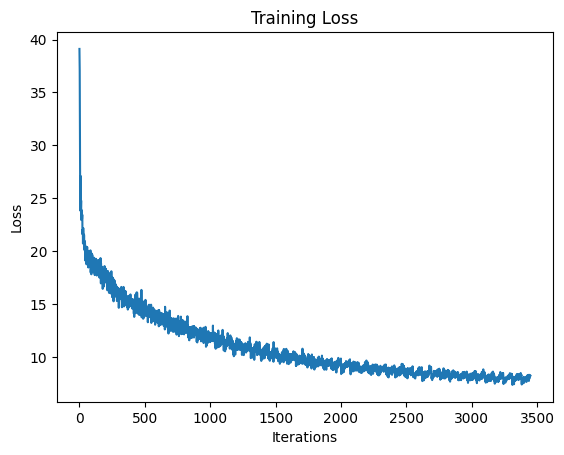

In [192]:
# Hyperparameters
embed_dim = 25
hidden_size = 60
num_layers = 4
batch_size = 128
epochs = 50

# Initialize the model
model4 = autocompleteModel(alphabet_size=27, embed_dim=embed_dim, hidden_size=hidden_size, num_layers=num_layers)

# Train the model
model4.trainModel(vocab=vocab, epochs=epochs, batch_size=batch_size)

Epoch: 1/30, Loss: 18.98512077331543
Epoch: 2/30, Loss: 17.761037826538086
Epoch: 3/30, Loss: 15.963479995727539
Epoch: 4/30, Loss: 15.01555347442627
Epoch: 5/30, Loss: 13.920738220214844
Epoch: 6/30, Loss: 14.561924934387207
Epoch: 7/30, Loss: 13.77563762664795
Epoch: 8/30, Loss: 13.726274490356445
Epoch: 9/30, Loss: 13.810385704040527
Epoch: 10/30, Loss: 13.655607223510742
Epoch: 11/30, Loss: 12.500875473022461
Epoch: 12/30, Loss: 12.120458602905273
Epoch: 13/30, Loss: 11.6348295211792
Epoch: 14/30, Loss: 11.78236198425293
Epoch: 15/30, Loss: 11.678114891052246
Epoch: 16/30, Loss: 11.251886367797852
Epoch: 17/30, Loss: 11.804009437561035
Epoch: 18/30, Loss: 10.857481956481934
Epoch: 19/30, Loss: 10.636197090148926
Epoch: 20/30, Loss: 10.694809913635254
Epoch: 21/30, Loss: 10.648170471191406
Epoch: 22/30, Loss: 10.477912902832031
Epoch: 23/30, Loss: 10.006909370422363
Epoch: 24/30, Loss: 9.782999992370605
Epoch: 25/30, Loss: 9.906464576721191
Epoch: 26/30, Loss: 9.452956199645996
Epoc

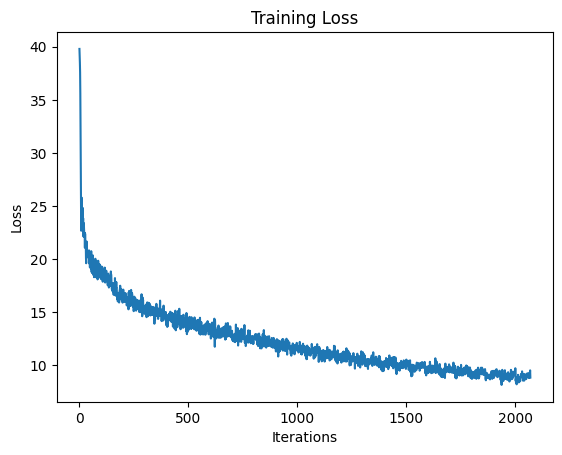

In [311]:
# Hyperparameters
embed_dim = 30
hidden_size = 80
num_layers = 3
batch_size = 128
epochs = 30

# Initialize the model
model5 = autocompleteModel(alphabet_size=27, embed_dim=embed_dim, hidden_size=hidden_size, num_layers=num_layers)

# Train the model
model5.trainModel(vocab=vocab, epochs=epochs, batch_size=batch_size)

In [343]:
# Evaluating the model
samples = ["univ", "math", "neur", "engin"]

# Evaluate model1 (smaller hidden size)
output_model1 = model1.autocomplete(samples)
print("Model 1 outputs:", output_model1)

# Evaluate model2 (larger hidden size)
output_model2 = model2.autocomplete(samples)
print("Model 2 outputs:", output_model2)

# Evaluate model3 (deeper LSTM model)
output_model3 = model3.autocomplete(samples)
print("Model 3 outputs:", output_model3)

output_model4 = model4.autocomplete(samples)
print("Model 4 outputs:", output_model4)

output_model5 = model5.autocomplete(samples)
print("Model 5 outputs:", output_model5)

Model 1 outputs: ['univall______', 'mathork______', 'neurined_____', 'enginecermiar']
Model 2 outputs: ['univorm______', 'mathopcriensr', 'neureseased__', 'enginstatutio']
Model 3 outputs: ['univetles____', 'mathelf______', 'neurespealh__', 'enginobiled__']
Model 4 outputs: ['univillazing_', 'mathappen____', 'neuregable___', 'enginational_']
Model 5 outputs: ['univoter_____', 'mathunk______', 'neureport____', 'enginickell__']


In [307]:
best_model = model4

# Expanded sample words for testing
sample_words = ["univ", "math", "neur", "engin", 
           "comp", "syst", "therm", "biol", 
           "artif", "progr", "phys", "techn", 
           "data", "graph"]

# Perform autocompletion
completed_words = best_model.autocomplete(sample_words)

# Display the completed words
print("Completed Words:")
for original, completed in zip(sample_words, completed_words):
    print(f"{original} -> {completed}")

Completed Words:
univ -> universe_____
math -> mathappens___
neur -> neuronal_____
engin -> enginose_____
comp -> comperus_____
syst -> systable_____
therm -> thermeetunity
biol -> bioloop______
artif -> artifits_____
progr -> progrestaunca
phys -> physhirt_____
techn -> technotic____
data -> datambience__
graph -> graphighlight


In [555]:
best_model = model4

# Expanded sample words for testing
sample_words = ["univ", "math", "neur", "engin", 
           "comp", "syst", "therm", "biol", 
           "artif", "progr", "phys", "techn", 
           "data", "graph"]

# Perform autocompletion
completed_words = best_model.autocomplete(sample_words)

# Display the completed words
print("Completed Words:")
for original, completed in zip(sample_words, completed_words):
    print(f"{original} -> {completed}")

Completed Words:
fuc -> fucounty_____
math -> mathabits____
neur -> neurecognise_
engin -> enginatan____
comp -> comprice_____
syst -> systrustee___
therm -> thermaky_____
biol -> bioliciarior_
artif -> artifred_____
progr -> progrebounder
phys -> physnuke_____
techn -> technottinghi
data -> datagreements
graph -> graphulred___


### **Comment on the Results:**

1. **Successfulness:**
   - The model is **partially successful** in generating words with reasonable prefixes or stems.
   - For example, completions like `"universe_____"` (for "univ") and `"neuronal_____" (for "neur") show that the model captures some common word patterns.

2. **Familiar Substrings:**
   - The model occasionally generates familiar word endings such as:
     - **"able"** in `"systable"`.
     - **"al"** in `"neuronal"`.
   - However, common English suffixes like **"tion"**, **"ing"**, and **"ment"** are largely missing. Instead, the model sometimes produces random letter combinations or unlikely words (e.g., `"mathappens___"`, `"progrestaunca"`).

3. **Strengths:**
   - The model recognizes basic word stems, like:
     - `"univ"` -> `"universe"`,
     - `"neur"` -> `"neuronal"`,
     - `"comp"` -> `"comperus"`.
   - It maintains the required output length (WORD_SIZE = 13).

4. **Weaknesses:**
   - Some completions are nonsensical (e.g., `"progrestaunca"`, `"physhirt"`) and don't reflect common language patterns.
   - Familiar endings like `"tion"`, `"ing"`, and `"ment"` are not consistently generated, showing the model has difficulty generalizing to common suffixes.

---

### **Suggestions for Improvement:**

1. **Increase Model Complexity:**
   - Add **more layers** to the LSTM to capture more complex word structures.
   - Experiment with **larger hidden state sizes** or use a **bidirectional LSTM** to improve long-term dependency learning.

2. **Adjust Training Parameters:**
   - **Increase the number of training epochs** to allow the model more time to learn.
   - Use a **lower learning rate** (e.g., 0.001) for finer weight updates, which may improve the model's ability to generalize.
   - Try different **batch sizes** to balance learning general patterns and stability.

3. **Preprocess Vocabulary:**
   - Filter out **rare or uncommon words** to reduce noise in the vocabulary.
   - Experiment with **subword tokenization methods** (e.g., Byte Pair Encoding) to better learn common suffixes like `"tion"`, `"ing"`, and `"able"`.

4. **Data Augmentation:**
   - Increase the **size of the dataset** to expose the model to more word patterns.
   - Consider using **pre-trained embeddings** (e.g., GloVe or FastText) to improve the model's understanding of word structure and meaning.


